In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import classification_report, accuracy_score

from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import pickle

plt.style.use('ggplot')

# Read Data

In [2]:
key = [f"{i}_px" for i in range(48*48)]
value = ['float32']*(48*48)
df = pd.read_csv('data.csv',dtype=dict(zip(key,value)))
del key, value
df.drop_duplicates(inplace=True)

In [3]:
X = df.iloc[:,:-1].to_numpy()
y = df['emotion'].to_numpy()

# Basic Data Analysis

In [4]:
df.shape

(28669, 2305)

In [5]:
unq, val = np.unique(y,return_counts=True)

unq , np.round(val / val.sum() * 100,2)

(array(['Angry', 'Fear', 'Happy', 'Sad', 'Suprise'], dtype=object),
 array([17.08, 17.03, 32.25, 21.94, 11.7 ]))

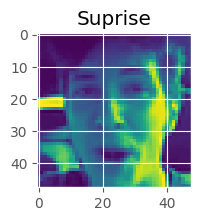

In [6]:
plt.figure(figsize=(2,2))
plt.imshow(X[60].reshape(48,48))
plt.title(y[60])
plt.show()

In [7]:
%%time
pca = PCA(n_components=None)
pca.fit(X)

CPU times: user 2min 5s, sys: 236 ms, total: 2min 5s
Wall time: 17.8 s


,n_components,None
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


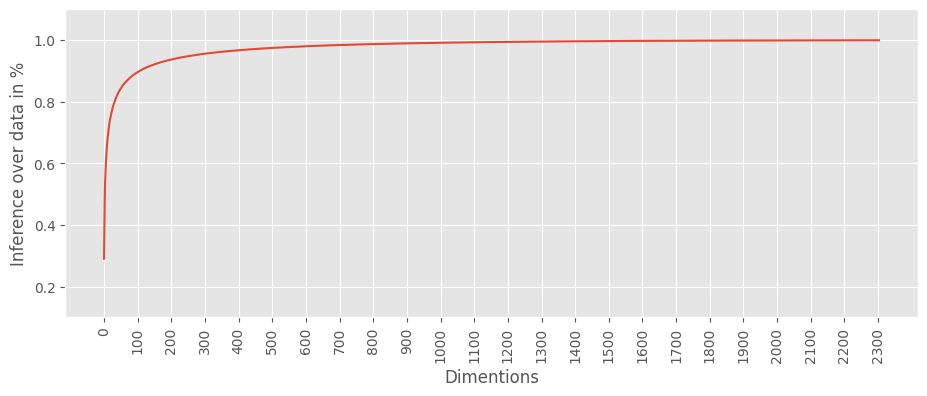

In [8]:
cum_percent_sum = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(11,4))
plt.plot(cum_percent_sum)
plt.xlabel("Dimentions")
plt.ylabel("Inference over data in %")
plt.xticks(range(0,2305,100),rotation=90)
plt.ylim([.1,1.1])
plt.show()

# Smart Sampling Data

In [9]:
%%time
smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)

CPU times: user 6min 7s, sys: 112 ms, total: 6min 7s
Wall time: 1min 38s


In [10]:
unq, val = np.unique(y_resampled,return_counts=True)

unq , np.round(val / val.sum() * 100,2)

(array(['Angry', 'Fear', 'Happy', 'Sad', 'Suprise'], dtype=object),
 array([23.76, 23.11,  1.29, 16.19, 35.65]))

# Model Testing

## Train Test Split

In [11]:
X_train,X_test,y_train,y_test = train_test_split(X_resampled,y_resampled,test_size=.2)

## Data Preprocessing and Feature Selection

In [12]:
lab_encoding = LabelEncoder()
processed_y_train = lab_encoding.fit_transform(y_train)
processed_y_test = lab_encoding.transform(y_test)

In [13]:
dict(zip(lab_encoding.classes_, lab_encoding.transform(lab_encoding.classes_)))

{'Angry': np.int64(0),
 'Fear': np.int64(1),
 'Happy': np.int64(2),
 'Sad': np.int64(3),
 'Suprise': np.int64(4)}

In [14]:
p_line = Pipeline([
    ('MinMax', MinMaxScaler()),
    ('PCA', PCA(n_components=400))
])

In [15]:
processed_X_train = p_line.fit_transform(X_train)
processed_X_test = p_line.transform(X_test)

## XGBoost Model Testing

In [16]:
%%time
boost = XGBClassifier()
boost.fit(processed_X_train,processed_y_train)

CPU times: user 11min 2s, sys: 686 ms, total: 11min 2s
Wall time: 1min 30s


,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [17]:
boost.score(processed_X_train,processed_y_train)

1.0

In [18]:
boost_pred = boost.predict(processed_X_test)

In [19]:
accuracy_score(boost_pred,processed_y_test)

0.8268041237113402

In [20]:
print(classification_report(processed_y_test, boost_pred))

              precision    recall  f1-score   support

           0       0.78      0.85      0.82      1025
           1       0.82      0.80      0.81       981
           2       1.00      0.19      0.32        64
           3       0.86      0.64      0.74       749
           4       0.85      0.94      0.89      1546

    accuracy                           0.83      4365
   macro avg       0.86      0.69      0.71      4365
weighted avg       0.83      0.83      0.82      4365



## Stacking Ensemble Testing

In [21]:
# estimators = [
#     ('svc', SVC(C=10,class_weight=None, gamma='scale',kernel='rbf')),
#     ('lgc', LogisticRegression(C=100,class_weight=None,penalty='l2',solver='lbfgs',max_iter=5000)),
#     ('xgboost', XGBClassifier(colsample_bytree=.8,gamma=.1,learning_rate=.01,max_depth=7, min_child_weight=1,n_estimators=600,
#                              reg_alpha=1,reg_lambda=1,subsample=1))
#              ]

In [22]:
estimators = [
    ('svc', SVC(C=10,class_weight=None, gamma='scale',kernel='rbf')),
    ('lgc', LogisticRegression(C=100,class_weight=None,penalty='l2',solver='lbfgs',max_iter=5000)),
    ('xgboost', XGBClassifier(colsample_bytree=.8,gamma=.1,learning_rate=.01,max_depth=7, min_child_weight=1,n_estimators=600,
                             reg_alpha=1,reg_lambda=1,subsample=1))
             ]

In [23]:
%%time
clf = StackingClassifier(estimators=estimators,
                         final_estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                                   learning_rate=.2,
                                                                   max_depth=5,
                                                                   max_features=None,
                                                                   min_samples_leaf=2,
                                                                   min_samples_split=20,
                                                                   n_estimators=300,
                                                                   subsample=.7),
                         stack_method='predict',
                         cv=10,
                         n_jobs=-1)

CPU times: user 109 μs, sys: 0 ns, total: 109 μs
Wall time: 120 μs


In [24]:
%%time
clf.fit(processed_X_train,processed_y_train)

CPU times: user 20.3 s, sys: 4.55 s, total: 24.8 s
Wall time: 1h 21s


,estimators,"[('svc', ...), ('lgc', ...), ...]"
,final_estimator,GradientBoost...subsample=0.7)
,cv,10
,stack_method,'predict'
,n_jobs,-1
,passthrough,False
,verbose,0
,C,10
,kernel,'rbf'
,degree,3
,gamma,'scale'


In [25]:
clf.score(processed_X_test,processed_y_test)

0.8907216494845361

In [26]:
clf.score(processed_X_train,processed_y_train)

0.9914074583261728

In [27]:
clf_pred = clf.predict(processed_X_test)

In [28]:
print(classification_report(processed_y_test, clf_pred))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1025
           1       0.89      0.88      0.89       981
           2       0.52      0.56      0.54        64
           3       0.90      0.73      0.81       749
           4       0.94      0.97      0.95      1546

    accuracy                           0.89      4365
   macro avg       0.82      0.81      0.81      4365
weighted avg       0.89      0.89      0.89      4365



# Cross_validetion

In [29]:
lab_encoding = LabelEncoder()
y_ = lab_encoding.fit_transform(y)

In [30]:
p_line = Pipeline([
    ('MinMax', MinMaxScaler()),
    ('PCA', PCA(n_components=400))
])

In [31]:
X_ = p_line.fit_transform(X)

In [32]:
# scores = cross_val_score(clf, X_, y_, cv=5)

In [33]:
# scores.mean(), scores.std()

# Final Model Selection

In [34]:
label_mapping = dict(zip(lab_encoding.classes_, lab_encoding.transform(lab_encoding.classes_)))
label_mapping

{'Angry': np.int64(0),
 'Fear': np.int64(1),
 'Happy': np.int64(2),
 'Sad': np.int64(3),
 'Suprise': np.int64(4)}

In [35]:
estimators = [
    ('svc', SVC(C=10,class_weight=None, gamma='scale',kernel='rbf')),
    ('lgc', LogisticRegression(C=100,class_weight=None,penalty='l2',solver='lbfgs',max_iter=5000)),
    ('xgboost', XGBClassifier(colsample_bytree=.8,gamma=.1,learning_rate=.01,max_depth=7, min_child_weight=1,n_estimators=600,
                             reg_alpha=1,reg_lambda=1,subsample=1))
             ]

In [36]:
%%time
clf = StackingClassifier(estimators=estimators,
                         final_estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                                   learning_rate=.2,
                                                                   max_depth=5,
                                                                   max_features=None,
                                                                   min_samples_leaf=2,
                                                                   min_samples_split=20,
                                                                   n_estimators=300,
                                                                   subsample=.7),
                         stack_method='predict',
                         cv=10,
                         n_jobs=-1)

CPU times: user 40 μs, sys: 0 ns, total: 40 μs
Wall time: 47.2 μs


In [37]:
%%time
clf.fit(X_,y_)

CPU times: user 39.2 s, sys: 9.17 s, total: 48.4 s
Wall time: 2h 28min 9s


,estimators,"[('svc', ...), ('lgc', ...), ...]"
,final_estimator,GradientBoost...subsample=0.7)
,cv,10
,stack_method,'predict'
,n_jobs,-1
,passthrough,False
,verbose,0
,C,10
,kernel,'rbf'
,degree,3
,gamma,'scale'


In [38]:
%%time
clf.score(X_,y_)

CPU times: user 4min 3s, sys: 66.1 ms, total: 4min 3s
Wall time: 3min 59s


0.9366911995535248

In [39]:
pickle.dump(clf, open('models/model_3.pkl','wb'))
pickle.dump(lab_encoding, open('models/labels_3.pkl','wb'))
pickle.dump(p_line, open('models/pipline_3.pkl','wb'))

In [40]:
# %%time
# boost = XGBClassifier()
# boost.fit(X_,y_)

In [41]:
# %%time
# boost.score(X_,y_)

In [42]:
# pickle.dump(boost, open('models/model-boost_1.pkl','wb'))